# Metropolis-Hastings - I. Finding the time shift between two noisy time series

A central theme in numerous applications is the estimation of time shifts between two noisy time series $s_1(t)$ and $s_2(t)$. This can be set as an inverse problem, where the model parameter $m$ is the time shift $\delta$. The goal is to obtain a probability density that describes the likelihood of $d=s_2(t-\delta)$ being equal to $s_1(t)$.

As data prior, $p(d|m)=p(d|\delta)$, we use a Gaussian with the standard deviation $\sigma$ set equal to the noise level in the data, i.e.

\begin{equation}
p(d|m) = const.\,\exp{\left[-\frac{1}{2N\sigma^2} \sum_{i=1}^N [s_1(t_i)-s_2(t_i-\delta)]^2\right]}\,,
\end{equation}

where $N$ is the number of samples in the time series. For the prior in model space, $p(m)=p(\delta)$, i.e. the prior information on $\delta$, we choose a constant. This corresponds to the assumption that we know very little about the time shift before looking at the actual time series.

The goal of this exercise is to sample the posterior distribution of the time shift $\delta$ with the Metropolis-Hastings algorithm and to determine the maximum-likelihood time shift using simulated annealing. We will use synthetically generated time series instead of real data, because this allows us to investigate the effect of the noise level on the quality of our inferences.

# 0. Import packages and set some parameters

In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "serif"
plt.rcParams.update({'font.size': 20})

# 1. Sampling the posterior
We start with the generation of two noisy time series. The only input parameter is the noise level, which we initially set to 10 % of the maximum amplitude of the time series.

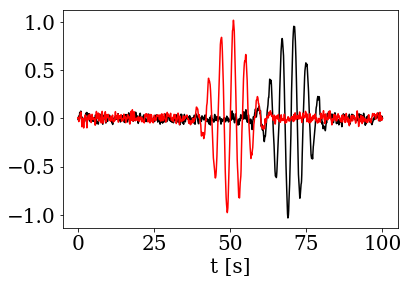

In [23]:
# Set the noise level.
noise_level=0.1

# Make two noise-free time series ---------------------------------

t=np.arange(0.0,100.0,0.01)
s1=np.sin(0.5*np.pi*(t-70.0))*np.exp(-0.5*(t-70.0)**2/25.0)
s2=np.sin(0.5*np.pi*(t-50.0))*np.exp(-0.5*(t-50.0)**2/25.0)

# Make some noise. ------------------------------------------------

# Plain random noise.
n1=np.zeros(len(s1))
n2=np.zeros(len(s2))
n1[1:-1]=np.random.randn(len(s1)-2)
n2[1:-1]=np.random.randn(len(s1)-2)

# Smoothing.
for it in range(100):
    n1_new=n1
    n2_new=n2
    n1_new[1:-1]=(n1[0:-2]+n1[2:]+n1[1:-1])/3.0
    n2_new[1:-1]=(n2[0:-2]+n2[2:]+n2[1:-1])/3.0

n1=n1_new/np.max(np.abs(n1_new))
n2=n2_new/np.max(np.abs(n2_new))
    
# Add scaled version to the time series.
s1+=n1*noise_level
s2+=n2*noise_level

# Plot the noisy time series. --------------------------------------

plt.plot(t,s1,'k')
plt.plot(t,s2,'r')
plt.xlabel('t [s]')
plt.title('noisy time series')
plt.show()

## 1.1 Sampling by grid search

To get a first impression of the posterior distribution, we use a simple grid search. As prior in model space we use, for simplicity, a constant.

**Exercise 1**: The posterior distribution should exhibit multiple peaks with a spacing of roughly $4$ s. What is the origin of these peaks? Why is there not just one?

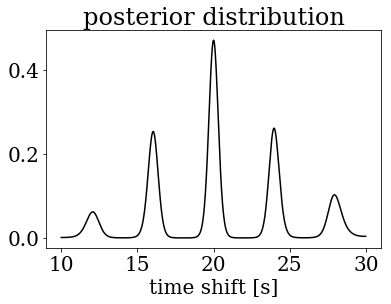

In [47]:
# Define the prior in data space. ----------------------------------

def prior_data(s1,s2,noise_level):
    p=np.sum((s1-s2)**2)/(len(s1)*noise_level**2)
    return np.exp(-p/2.0)

# March through all possible time shifts. --------------------------
    
# Test time shifts.
delta=np.arange(10.0,30.0,0.01)

# Initialise posterior distribution.
p=np.zeros(len(delta))

# March through all possible time shifts.
for n in range(len(delta)):
    
    # Make test time series by shifting s2.
    s=np.zeros(len(s1))
    s[4000:8000]=s2[(3000-n):(7000-n)]
    
    # Evaluate posterior.
    p[n]=prior_data(s,s1,noise_level)
    
# Normalise distribution.
p=p/(0.01*np.sum(p))

# Plot posterior. --------------------------------------------------

plt.plot(delta,p,'k')
plt.xlabel('time shift [s]')
plt.title('posterior distribution')
plt.show()

## 1.2 Sampling with the Metropolis-Hastings algorithm

Having some ground truth from the grid search, we try to sample the posterior with the Metropolis-Hastings algorithm. The proposals are uniformly distributed between $10$ and $30$ s time shift. The input parameters are the total number of proposals (samples, currently set to $1000$) and the number of histogram bins (currently $20$) used to plot the posterior.

**Exercise 2**: How does the obtained histogram of the samples compare to the posterior obtained from the systematic grid search?

**Exercise 3**: Reduce the bin width of the histograms to $0.1$, while leaving the number of samples at $1000$. Is the resulting histogram a meaningful approximation of the posterior?

**Exercise 4**: Set the noise level to $0.2$ and the number of bins to 50. Estimate the number of samples needed to obtain a reasonable approximation of the posterior, by successively increasing the number of proposals. (This is obviously subjective, so please provide a justification of your choice.)

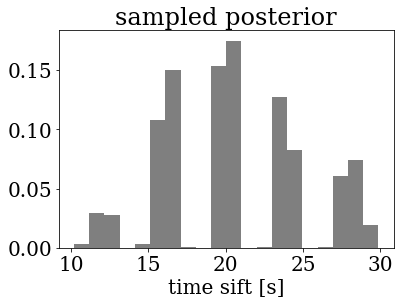

In [74]:
# Some input. ------------------------------------------------------

# Number of histogram bins.
n_bin=20
# Total number of proposed samples.
number_of_samples=1000

# Make the first random sample. ------------------------------------

samples=np.zeros(number_of_samples)

# Random time shift between 10 and 30.
samples[0]=20.0+20.0*(np.random.rand()-0.5)

# Make test time series by shifting s2.
s=np.zeros(len(s1))
n=np.int(100.0*samples[0])
s[4000:8000]=s2[(4000-n):(8000-n)]

# Evaluate posterior for the first sample.
p=prior_data(s,s1,noise_level)

# Run Metropolis-Hastings sampler. ---------------------------------

for i in range(1,number_of_samples):
    
    # Random time shift proposal.
    delta_test=20.0+20.0*(np.random.rand()-0.5)
    
    # Make test time series by shifting s2.
    s=np.zeros(len(s1))
    n=np.int(100.0*delta_test)
    s[4000:8000]=s2[(4000-n):(8000-n)]
    
    # Evaluate posterior.
    p_test=prior_data(s,s1,noise_level)
    
    # Apply Metropolis rule.
    if (p_test/p>np.random.rand()):
        p=p_test
        samples[i]=delta_test
    else:
        samples[i]=samples[i-1]

# Plot results. ----------------------------------------------------

n, bins, patches = plt.hist(samples, n_bin, density=True, facecolor='k', alpha=0.5)
plt.xlabel('time sift [s]')
plt.title('sampled posterior')
plt.show()

# 2. Finding the maximum-likelihood model by Simulated Annealing

In the following, we modify the Metropolis-Hastings algorithm from above such that it becomes a Simulated Annealing algorithm. Input parameters include the number of random samples, the cooling constant that determines the gradual temperature decrease, and the initial temperature. We again work with artificial data where the noise level is $0.1$.

**Exercise 5**: Run the Simulated Annealing code below with the default input values (number of samples=$1000$, cooling constant=$0.99$, initial temperature=$1.0$). What is the estimated maximum likelihood time shift? To which extent does it agree with the estimate from the grid search and the Metropolis-Hastings sampling?

**Exercise 6**: Reduce the cooling constant to $0.8$ and repeat the Simulated Annealing. (Do this several times. Simulated Annealing is a random algorithm, so the results will be different each time.) Why does the algorithm not generally succeed in finding a reasonable estimate of the maximum-likelihood time shift? Estimate the minimum cooling constant than ensures a useful result.

**Exercise 7**: Use the results from the grid search to determine the true maximum-likelihood point. (You may zoom into the figure until you see the peak of the posterior distribution.) Find a cooling constant and a number of samples that reliably finds the true maximum-likelihood time shift with an error of less than $0.05$ s.

estimated maximum-likelihood time shift: 19.883637 s


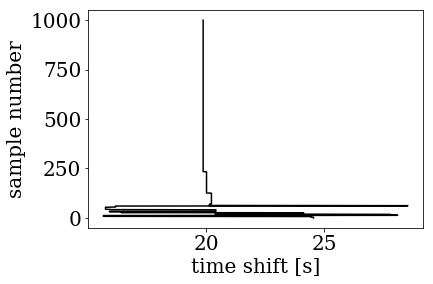

In [84]:
# Some input. ------------------------------------------------------

# Total number of proposed samples.
number_of_samples=1000
# Cooling constant (T[i+1]=cooling_constant*T[i]).
cooling_constant=0.99
# Initial temperature.
T_0=1.0

# Compute first sample and evaluate its posterior. -----------------

samples=np.zeros(number_of_samples)

# Random time shift between 10 and 30.
samples[0]=20.0+20.0*(np.random.rand()-0.5)

# Make test time series by shifting s2.
s=np.zeros(len(s1))
n=np.int(100.0*samples[0])
s[4000:8000]=s2[(4000-n):(8000-n)]

# Evaluate posterior for the first sample.
p=prior_data(s,s1,noise_level)

# Set temperature to initial temperature.
T=T_0

# Random walk with decreasing temperature. -------------------------

for i in range(1,number_of_samples):
    
    # Random time shift proposal.
    delta_test=20.0+20.0*(np.random.rand()-0.5)
    
    # Make test time series by shifting s2.
    s=np.zeros(len(s1))
    n=np.int(100.0*delta_test)
    s[4000:8000]=s2[(4000-n):(8000-n)]
    
    # Evaluate posterior.
    p_test=prior_data(s,s1,noise_level*np.sqrt(T/T_0))
    
    # Apply Metropolis rule.
    if (p_test/p>np.random.rand()):
        p=p_test
        samples[i]=delta_test
    else:
        samples[i]=samples[i-1]
        
    # Update temperature.
    T=cooling_constant*T

# Output results. --------------------------------------------------

print('estimated maximum-likelihood time shift: %f s' % samples[-1])

plt.plot(samples,range(number_of_samples),'k')
plt.xlabel('time shift [s]')
plt.ylabel('sample number')
plt.show()